<a href="https://colab.research.google.com/github/t0ccata/final-project-ml/blob/main/Playground_SVM_Normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from math import sqrt

In [24]:
data_rnn = pd.read_csv("https://raw.githubusercontent.com/t0ccata/final-project-ml/main/archive/daily/AALI.csv")
data_rnn['timestamp'] = pd.to_datetime(data_rnn['timestamp'])
data_rnn.set_index('timestamp', inplace=True)
data_rnn.head()

,open,low,high,close,volume
timestamp,,,,,
2001-04-16,524,524,547,547,342131
2001-04-17,547,524,571,524,345804
2001-04-18,547,524,547,524,230361
2001-04-19,524,500,524,500,457574
2001-04-20,476,452,476,452,228262


In [25]:
data_rnn.isna().sum()

open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [26]:
# split data menjadi test dan train

train_size = int(len(data_rnn) * 0.8)
data_train, data_test = data_rnn[:train_size], data_rnn[train_size:]

In [27]:
# Normalisasi setelah di split

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.transform(data_test)

In [28]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])
    return np.array(sequences), np.array(targets)

seq_length = 60
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

In [29]:
# split train menjadi train dan validation set

train_val_split = int(len(X_train) * 0.8)
X_train_final, X_val = X_train[:train_val_split], X_train[train_val_split:]
y_train_final, y_val = y_train[:train_val_split], y_train[train_val_split:]

In [30]:
if X_train_final.ndim > 2:
    X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)

if X_val.ndim > 2:
    X_val = X_val.reshape(X_val.shape[0], -1)

if X_test.ndim > 2:
    X_test = X_test.reshape(X_test.shape[0], -1)

In [31]:
model = SVR(kernel='rbf', C=1e3, gamma=0.1)
model.fit(X_train_final, y_train_final)

SVR(C=1000.0, gamma=0.1)

In [32]:
train_predictions = model.predict(X_train_final)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

In [33]:
# Evaluasi untuk data training
mse_train = mean_squared_error(y_train_final, train_predictions)
mape_train = mean_absolute_percentage_error(y_train_final, train_predictions)
r2_train = r2_score(y_train_final, train_predictions)

print(f'Normalized Data Metrics:')
print(f'MSE: {mse_train}')
print(f'MAPE: {mape_train}')
print(f'R2 Score: {r2_train}')

Normalized Data Metrics:
MSE: 0.0019262229114145658
MAPE: 0.6043980659108705
R2 Score: 0.9758605415905267


In [34]:
# Evaluasi untuk data validasi
mse_val = mean_squared_error(y_val, val_predictions)
mape_val = mean_absolute_percentage_error(y_val, val_predictions)
r2_val = r2_score(y_val, val_predictions)

print(f'Validation Data Metrics:')
print(f'MSE: {mse_val}')
print(f'MAPE: {mape_val}')
print(f'R2 Score: {r2_val}')

Validation Data Metrics:
MSE: 0.0010841116358041058
MAPE: 0.054911867969505715
R2 Score: 0.8656546616950458


In [35]:
# Evaluasi untuk tes data
mse_test = mean_squared_error(y_test, test_predictions)
mape_test = mean_absolute_percentage_error(y_test, test_predictions)
r2_test = r2_score(y_test, test_predictions)

print(f'Test Data Metrics:')
print(f'MSE: {mse_test}')
print(f'MAPE: {mape_test}')
print(f'R2 Score: {r2_test}')

Test Data Metrics:
MSE: 0.0011587372304622803
MAPE: 0.10593452559466932
R2 Score: 0.6531407126313855


In [36]:
# Inverse Scaling untuk visualisasi
def inverse_transform(targets, predictions):
    targets_scaled = np.zeros((len(targets), 5))
    targets_scaled[:, 3] = targets
    targets_actual = scaler.inverse_transform(targets_scaled)[:, 3]

    predictions_scaled = np.zeros((len(predictions), 5))
    predictions_scaled[:, 3] = predictions
    predictions_actual = scaler.inverse_transform(predictions_scaled)[:, 3]

    return targets_actual, predictions_actual

y_train_actual, train_predictions_actual = inverse_transform(y_train, train_predictions)
y_val_actual, val_predictions_actual = inverse_transform(y_val, val_predictions)
y_test_actual, test_predictions_actual = inverse_transform(y_test, test_predictions)

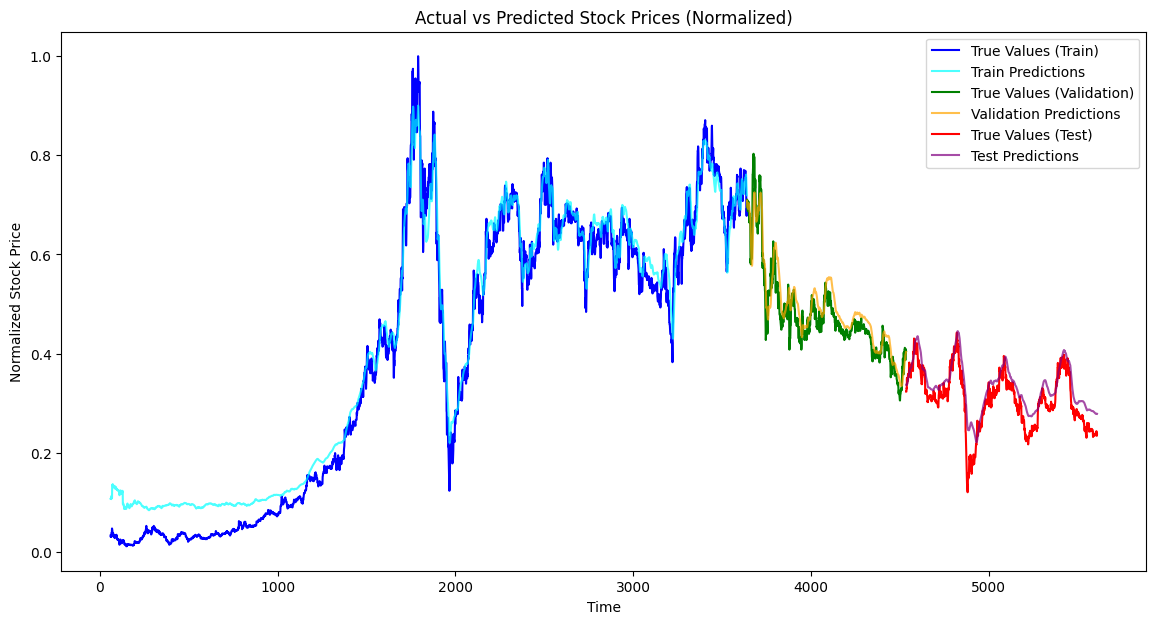

In [37]:
# Visualisasi
plt.figure(figsize=(14, 7))
plt.plot(range(seq_length, seq_length + len(y_train_final)), y_train_final, label='True Values (Train)', color='blue')
plt.plot(range(seq_length, seq_length + len(train_predictions)), train_predictions, label='Train Predictions', color='cyan', alpha=0.7)
plt.plot(range(seq_length + len(y_train_final), seq_length + len(y_train_final) + len(y_val)), y_val, label='True Values (Validation)', color='green')
plt.plot(range(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(val_predictions)), val_predictions, label='Validation Predictions', color='orange', alpha=0.7)
plt.plot(range(seq_length + len(y_train_final) + len(y_val), seq_length + len(y_train_final) + len(y_val) + len(y_test)), y_test, label='True Values (Test)', color='red')
plt.plot(range(seq_length + len(train_predictions) + len(val_predictions), seq_length + len(train_predictions) + len(val_predictions) + len(test_predictions)), test_predictions, label='Test Predictions', color='purple', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Normalized)')
plt.show()